In the summer of 2014, San Francisco had a rash of car breakins.  The most likely times for a breakin to occur were in the late evenings on weekends (Friday, Saturday, Sunday), and the most likely location was in the Southern police district.  Analysis to support this follows.  Note that the crime statistics during this time period may or may not have been an anomaly for San Francisco, this study focuses solely on the summer of 2014.

To begin, we'll install some basic packages and read in our input file.  We'll pare down the input by removing anything classified as non-criminal, as well as dropping some columns that we're not interested in.

In [1]:
library(tidyverse)
sf_incidents <- read.csv("sanfrancisco_incidents_summer_2014.csv")
crimOnly <- subset(sf_incidents, Category != "NON-CRIMINAL", select = c(Category, Descript, DayOfWeek, Time, PdDistrict, Resolution))

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Order the days of the week in Mon-Sun order to make sure everything is presented consistently:

In [4]:
crimOnly$DayOfWeek <- ordered(crimOnly$DayOfWeek, levels = c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"))

Now let's get a count of crime categories, aggregated by the day of the week:

In [5]:
crimGroup <- crimOnly %>% group_by(Category,DayOfWeek) %>% count() %>% ungroup()

A sample of the aggregated data (the full dataset is still too unwieldy to display at this point):

In [6]:
head(crimGroup, n=10)

Category,DayOfWeek,n
<fct>,<ord>,<int>
ARSON,Monday,7
ARSON,Tuesday,8
ARSON,Wednesday,13
ARSON,Thursday,8
ARSON,Friday,5
ARSON,Saturday,10
ARSON,Sunday,12
ASSAULT,Monday,406
ASSAULT,Tuesday,356


A graph showing all crime categories that had an aggregate of > 200 instances over the time period in our dataset; there are many categories that only had a few occurrences, so we'll ignore those.   (Note:  The fancy formula in scale_y_continuous is to force the y-axis to integers since that's what we're dealing with.):

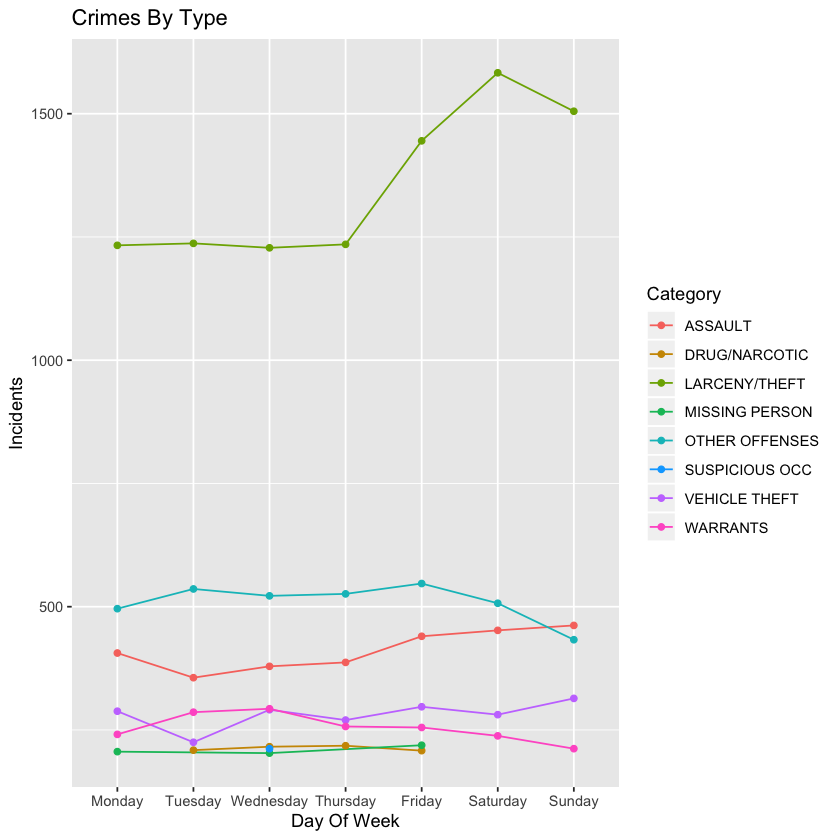

In [7]:
ggplot(crimGroup[crimGroup$n > 200,], aes(DayOfWeek, n, group=Category, col=Category)) + geom_line() + geom_point() + labs(x="Day Of Week", y="Incidents", title="Crimes By Type") + scale_y_continuous(breaks = function(x) unique(floor(pretty(seq(0, (max(x) + 1) * 1.1)))))

Clearly Larceny/theft is the biggest problem here, so we'll turn our attention to that (note here that we're going back to our first cleaned dataset to avoid introducing any compound errors):

In [8]:
larceny <- subset(crimOnly, Category == "LARCENY/THEFT", select = c(Category, Descript, DayOfWeek, Time, PdDistrict, Resolution))

Now that we've found the category with the highest occurence, let's split it out into its atomic types ("Descript" in the original dataset):

In [9]:
larcenyByType <- larceny %>% group_by(Descript,DayOfWeek) %>% count() %>% ungroup()

Plot a graph of all of the types of larceny with more than 50 occurrences reported:

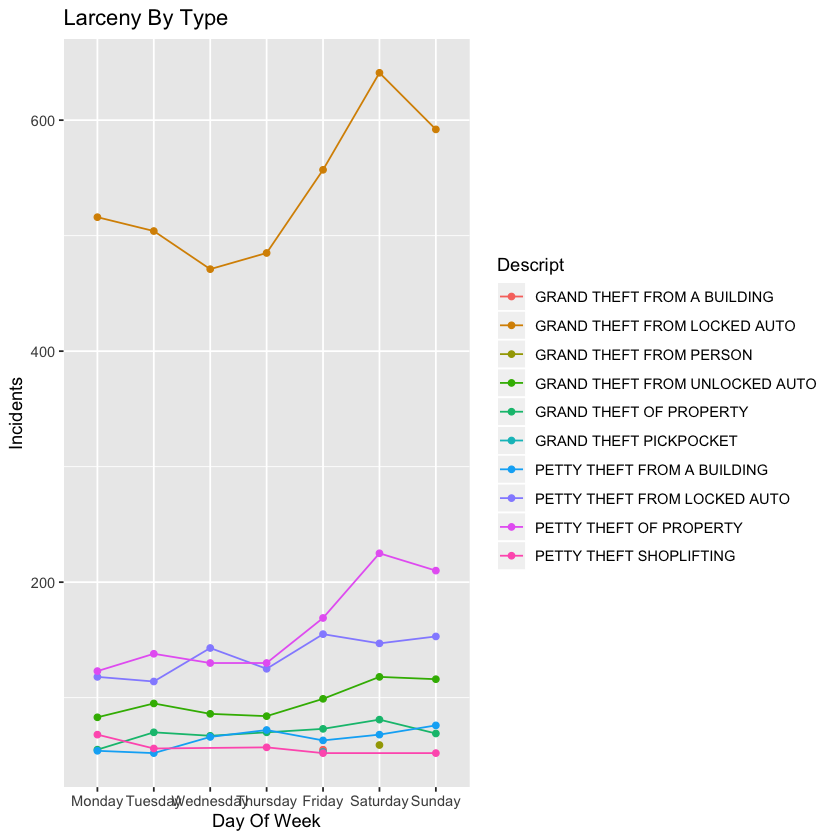

In [10]:
ggplot(larcenyByType[larcenyByType$n > 50,], aes(DayOfWeek, n, group=Descript, col=Descript)) + geom_line() + geom_point() + labs(x="Day Of Week", y="Incidents", title="Larceny By Type")

Of all the types of larceny reported, Grand Theft From A Locked Auto is far and away the most common.  We'll focus on that from here on out.

In [11]:
lockedAuto <- subset(larceny, Descript == "GRAND THEFT FROM LOCKED AUTO")

There are a few potentially interesting things we can try to correlate here, such as police district, time of day, and an obvious spike on weekends (Friday, Saturday, Sunday).  In order to try and avoid drowning in code, I will do all steps at once.

In [12]:
lockedAutoByDist <- lockedAuto %>% group_by(PdDistrict, DayOfWeek) %>% count() %>% ungroup()
lockedAutoByTime <- lockedAuto %>% group_by(Time, DayOfWeek) %>% count() %>% ungroup
tmpWknd <- subset(lockedAuto, (DayOfWeek=="Friday"|DayOfWeek=="Saturday"|DayOfWeek=="Sunday"))
lockedAutoWknd <- tmpWknd %>% group_by(Time, DayOfWeek) %>% count() %>% ungroup()

If we plot the incidents of all days aggregated by time, we see that there are very few breakins between the hours of midnight and ten AM:

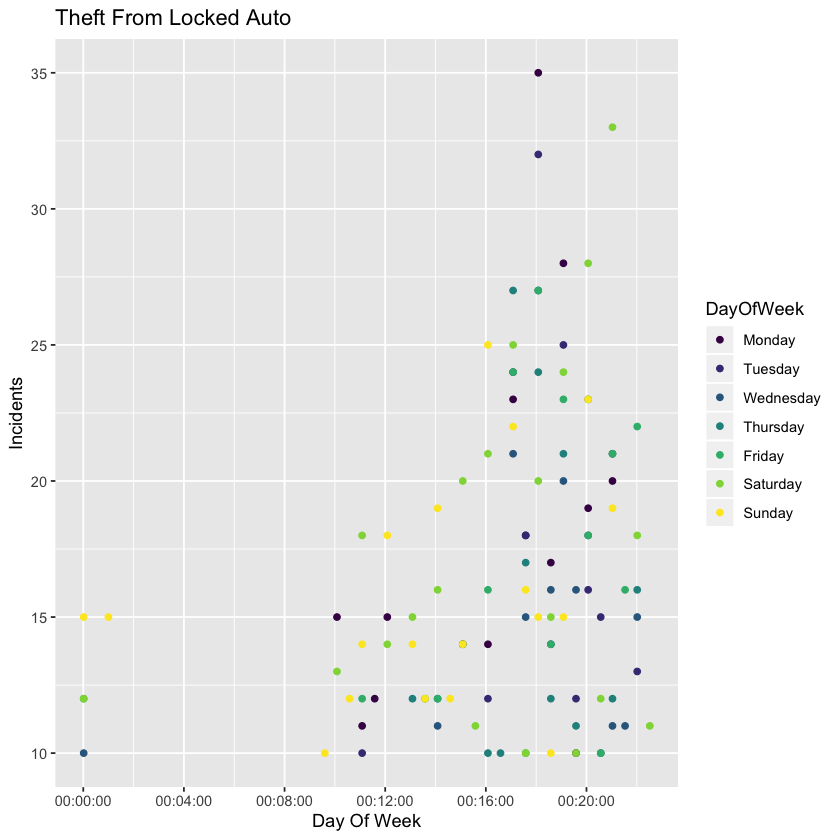

In [18]:
ggplot(lockedAutoByTime[lockedAutoByTime$n > 9,], aes(Time, n, col=DayOfWeek)) + labs(x="Day Of Week", y="Incidents", title="Theft From Locked Auto") + geom_point() + scale_x_time()

If we plot by time only over the weekend days, we see an upward trend from about noon each day, with the weekend peak at roughly 9:00 Saturday night.

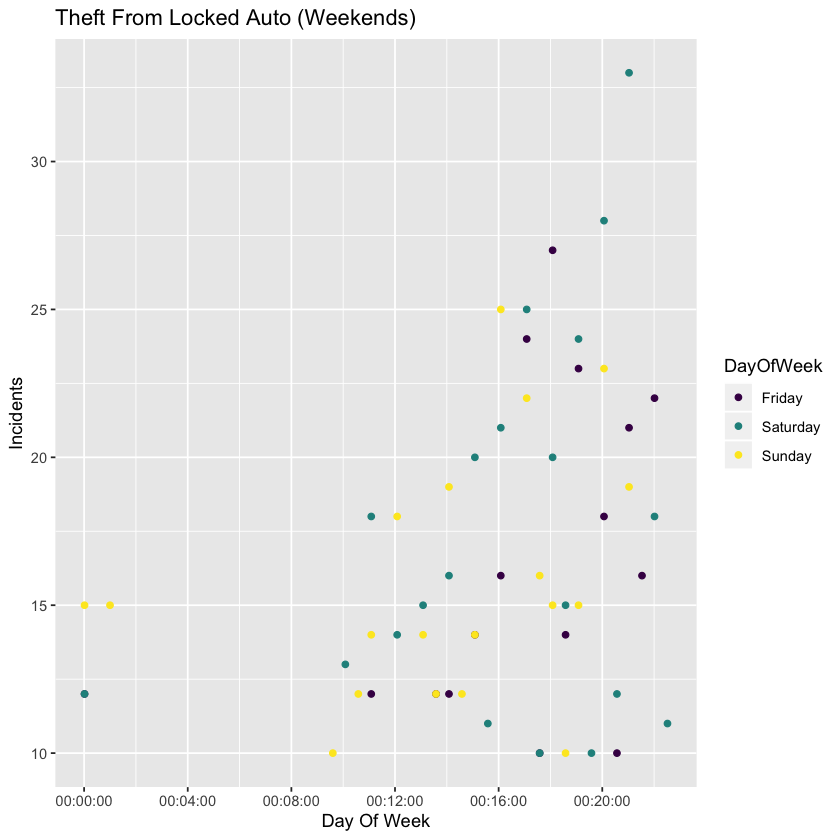

In [19]:
ggplot(lockedAutoWknd[lockedAutoWknd$n > 9,], aes(Time, n, col=DayOfWeek))+ labs(x="Day Of Week", y="Incidents", title="Theft From Locked Auto (Weekends)") + geom_point() + scale_x_time()

If we plot by district, we can see that the Southern district is at the highest risk of a car breakin occuring:

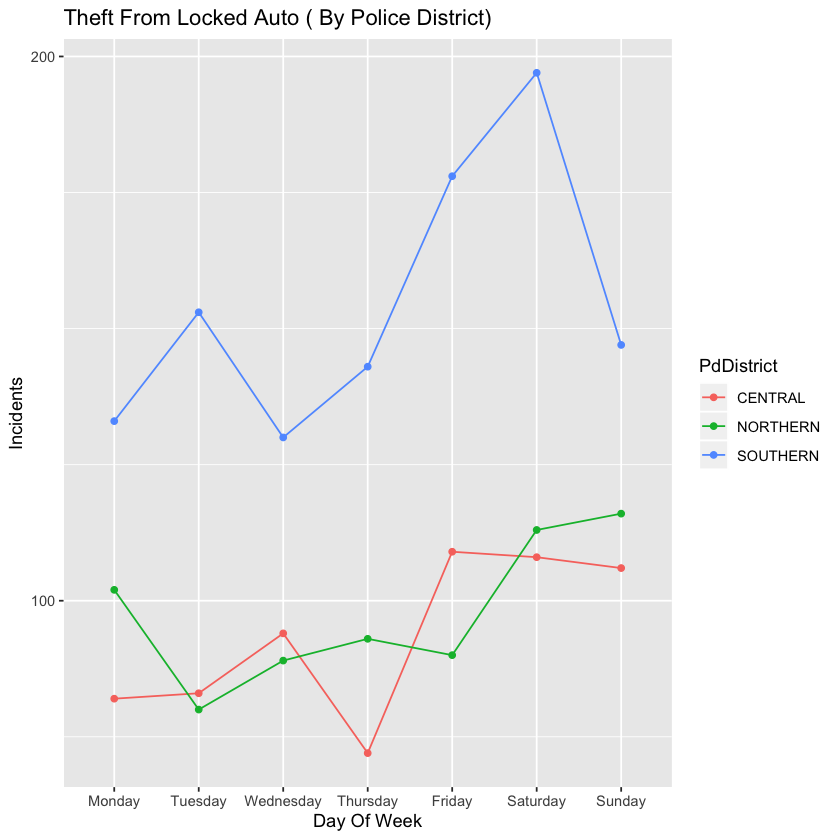

In [21]:
ggplot(lockedAutoByDist[lockedAutoByDist$n > 50,], aes(DayOfWeek, n, group=PdDistrict, col=PdDistrict)) + geom_line() + geom_point() + labs(x="Day Of Week", y="Incidents", title="Theft From Locked Auto ( By Police District)") + scale_y_continuous(breaks = seq(0, 2000, by=100), minor_breaks = seq(0,2000, by = 25))

I think you'll agree that, all in all, Saturday evenings were a risky time to park your car in the Southern district of San Francisco during the summer of 2014.